## 2 site Fermi Hubbard Non Hermitian VQA

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from qiskit.quantum_info import SparsePauliOp

ns = 2
numq = 2*ns
t = 2.0 
U = 1.0

mu = 1.5
delta = 0.0
gamma = 1.0
U = U + 0.5j*gamma

X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])


string = numq*[I]
C = []
for i in range(numq):
    string[0:i] = i*[Z]
    string[i] = 0.5*(X + 1j*Y)
    total = string[0]
    for j in range(1,numq):
        total = np.kron(total,string[j])

    C.append(total)

Hopp = np.zeros([2**numq,2**numq])
Self = np.zeros([2**numq,2**numq])
Chem = np.zeros([2**numq,2**numq])

for j in range(ns-1):
    Hopp = Hopp + (-t)*(1+delta)*C[j].T.conj()@C[j+1] + (-t)*(1-delta)*C[j+1].T.conj()@C[j]
    Hopp = Hopp + (-t)*(1+delta)*C[j+ns].T.conj()@C[j+1+ns] + (-t)*(1-delta)*C[j+1+ns].T.conj()@C[j+ns]

for j in range(ns):
    Self = Self + C[j].T.conj()@C[j]@C[j+ns].T.conj()@C[j+ns]
    Chem = Chem + C[j].T.conj()@C[j] + C[j+ns].T.conj()@C[j+ns]
    
Hamilton = Hopp + U*Self #- mu*Chem
# print(Hamilton.real)

pauli_s3 = SparsePauliOp.from_operator(Hamilton)

print(pauli_s3)

SparsePauliOp(['IIII', 'IIIZ', 'IIXX', 'IIYY', 'IIZI', 'IZII', 'IZIZ', 'XXII', 'YYII', 'ZIII', 'ZIZI'],
              coeffs=[ 0.5 +0.25j , -0.25-0.125j, -1.  +0.j   , -1.  +0.j   , -0.25-0.125j,
 -0.25-0.125j,  0.25+0.125j, -1.  +0.j   , -1.  +0.j   , -0.25-0.125j,
  0.25+0.125j])


In [41]:
from qiskit import QuantumCircuit
import scipy.linalg as la
import numpy as np
from qiskit.primitives import Estimator
from qiskit.quantum_info import Operator, SparsePauliOp
from scipy.optimize import minimize
from qiskit.circuit.library import TwoLocal

# H = SparsePauliOp(['IIII', 'IIIZ', 'IIXX', 'IIXY', 'IIYX', 'IIYY', 'IIZI', 'IZII', 'IZIZ', 'XXII', 'XYII', 'YXII', 'YYII', 'ZIII', 'ZIZI'],
#                   [-2.5+0.075j ,  0.5-0.0375j, -1.0    , -0.5j   ,  0.5j   , -1.0    ,  0.5-0.0375j,  
#                       0.5-0.0375j,  0.25+0.0375j, -1.0  , -0.5j   ,  0.5j   , -1.0  ,  0.5-0.0375j,  0.25+0.0375j])

H = pauli_s3

def VQA_1st_Step(theta, Er):
    
  ## theta contains Ei as first element
  Ei = theta[0]
  qc = ansatz.assign_parameters(theta[1:])
  H_minusE = H + SparsePauliOp([H.num_qubits*'I'],[-Er - 1j*Ei])
  operator = (H_minusE.conjugate() @ H_minusE).simplify()
  estimator = Estimator()
  result = estimator.run(qc, operator).result()
  return result.values[0]


def VQA_2nd_Step(theta):
    
  ## theta contains Er and Ei as 1st two elements
  Er = theta[0] ; Ei = theta[1] 
  qc = ansatz.assign_parameters(theta[2:])
  H_minusE = H + SparsePauliOp([H.num_qubits*'I'],[-Er - 1j*Ei])
  operator = (H_minusE.conjugate() @ H_minusE).simplify()
  estimator = Estimator()
  result = estimator.run(qc, operator).result()
  return result.values[0]


def get_energy(Er0, Ei0):
    
    x0 = np.random.random( len(ansatz.parameters) + 1 )

    x0[0] = Ei0

    result1 = minimize(lambda theta: VQA_1st_Step(theta,Er0), x0 = x0, method="BFGS") 

    x1 = np.concatenate(([Er0], result1.x))

    result2 = minimize(VQA_2nd_Step, x0 = x1, method="BFGS") 

    return [ result2.x[0], result2.x[1], result2.fun ]

ansatz = TwoLocal(H.num_qubits, ['ry', 'rz'], 'cz',reps=4)

# get_energy(1.0,1.0)

In [46]:
import random
Er0 = -4.0
E_max = 4.0
delE = 0.3

Eset0 = []

while (Er0 < E_max):

    Ei0 = random.randint(1,5)
    print(Ei0)
    
    result0 = get_energy(Er0, Ei0)
    
    Er = result0[0]
    Ei = result0[1]
    
    if result0[2] < 1.0e-05:
        Eset0.append(Er+1j*Ei)
        print(Er + 1j*Ei)
        print('LOSS: ',result0[2])

    result1 = get_energy(Er0, -1.0*Ei0)

    Er = result1[0]
    Ei = result1[1]

    if result1[2] < 1.0e-05:
        Eset0.append(Er+1j*Ei)
        print(Er + 1j*Ei)
        print('LOSS: ',result1[2])

    Er0 += delE


1
(-3.523489441075243+0.21893248469837387j)
LOSS:  4.720384499945496e-11
(-3.523489391074453+0.2189334474144103j)
LOSS:  4.451463975208014e-09
2
(-2.000001267544199-5.664895540457419e-08j)
LOSS:  3.125512806360035e-11
(-3.5234889960162916+0.21893253449120634j)
LOSS:  3.029054160275102e-09
1
(-2-6.050642143186959e-07j)
LOSS:  4.702735731439611e-07
(-2-1.4949064975600303e-07j)
LOSS:  1.2297790025842288e-11
1
(-1+0.5000002158937739j)
LOSS:  6.365482900685066e-11
(-1+0.49999952768724254j)
LOSS:  1.6018377065050009e-09
2
6.471753207691963e-05j
LOSS:  2.10294348358675e-08
-2.118800106348761e-05j
LOSS:  1.4941480691588183e-10
4
(1+0.49999955328956j)
LOSS:  2.2344736052259658e-09
(1+0.5000001721343724j)
LOSS:  1.1296434743366898e-11
3
(2+1.049388616170016e-07j)
LOSS:  1.3234085995380619e-10
(2-5.89155592185906e-08j)
LOSS:  3.895310447355272e-11
4
(3+0.4999998548288238j)
LOSS:  1.1736030013096687e-10
(3+0.4999997014088274j)
LOSS:  2.148444789191737e-11


In [68]:
Eset = list(set([elem.round(3) for elem in Eset0]))
Erset = [elem.real for elem in Eset]
Eiset = [elem.imag for elem in Eset]

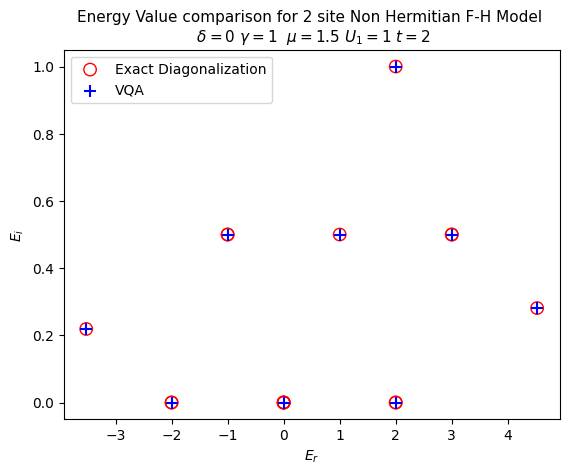

In [70]:
import matplotlib.pyplot as plt

main = la.eig(H)[0]
plt.xlabel('$E_r$')
plt.ylabel('$E_i$')
plt.scatter(main.real,main.imag,s= 80, facecolors = 'none', edgecolor = 'r',label = 'Exact Diagonalization')
plt.scatter(Erset,Eiset,s=70,marker = '+',label='VQA',color='b')
plt.legend()
plt.title("Energy Value comparison for 2 site Non Hermitian F-H Model \n "+ r"$\delta = 0 $ $\gamma = 1$  $\mu = 1.5$ $U_1 = 1$ $t = 2$", fontsize = 11)

plt.show()

In [65]:
main.round(2)

array([ 3.  +0.5j , -1.  +0.5j ,  2.  +0.j  , -2.  +0.j  ,  2.  +0.j  ,
       -2.  +0.j  , -3.52+0.22j,  4.52+0.28j, -0.  -0.j  , -1.  +0.5j ,
        3.  +0.5j ,  1.  +0.5j ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,
        2.  +1.j  ])